## 拓展实验：
### （1） 使用朴素贝叶斯实现垃圾邮件分类。实验数据可以自己拟定，也可使用给定的数据集。
### （2） 也可以使用朴素贝叶斯对社区留言板等社交平台的两种极端（积极的，消极的）评价进行文本情感分类。

# ①使用朴素贝叶斯实现垃圾邮件分类。实验数据可以自己拟定，也可使用给定的数据集。

In [1]:
from datetime import timedelta
import torch
import torch.nn as nn
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')


#### 加载数据集

In [2]:
df = pd.read_table('data/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

In [3]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# 改为数字
df['label'] = df.label.map({'ham': 0, 'spam': 1})  

In [5]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['message'] = df.message.map(lambda x: x.lower()) 

In [7]:
# 观察结果
df['message']

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: message, Length: 5572, dtype: object

In [8]:
# 向量化
tokenizer=ToktokTokenizer()
# 停用词
stopword_list=nltk.corpus.stopwords.words('english')

In [9]:
# 去掉html标签
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# 去掉多余空格
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# 去掉噪声
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
df['message']=df['message'].apply(denoise_text)

In [10]:
# 去掉特殊字符
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
df['message']=df['message'].apply(remove_special_characters)

In [11]:
stop=set(stopwords.words('english'))
print(stop)

# 去掉停留词
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
df['message']=df['message'].apply(remove_stopwords)

{'wouldn', 've', "haven't", 'those', 'shan', 'aren', 'through', 'he', 'who', 'my', "you're", 'hers', 'does', 'mightn', 'you', 'here', 'doing', 'down', 'own', 'his', "aren't", "she's", 'that', 'it', 'more', 'o', 'any', "needn't", 'himself', "don't", 'these', 'other', 'for', 'such', 'yourself', 'theirs', 'what', 'below', 'as', 'not', 'hasn', 'be', 's', 'between', 'her', 'were', 'no', 'had', 'under', "didn't", 'on', 'has', "mustn't", 'an', 'of', 'them', 'why', "you've", 'whom', "shouldn't", 'myself', 'out', 'after', 'hadn', 'only', 'same', 'too', 'by', 'so', 'she', "doesn't", 'shouldn', "shan't", 'then', 'our', 'its', 'with', 'from', 'very', 'their', 'over', 'mustn', 'because', 'until', 'few', "should've", 'just', 'was', 'if', 'didn', 'i', "it's", 'couldn', "that'll", 'ours', 'weren', 'or', 'me', 're', 'needn', 'yours', 'ourselves', 'into', 'before', 'all', 'is', 'they', 'once', 'doesn', 'off', "wasn't", 'been', 'further', 'him', 'at', 'have', 'while', 'do', 'but', 'against', 'during', 'd

In [12]:
import nltk  

In [13]:
df['message'] = df['message'].apply(nltk.word_tokenize)  

In [14]:
df

,label,message
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t..."
...,...,...
5567,1,"[2nd, time, tried, 2, contact, u, u, 750, poun..."
5568,0,"[b, going, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestions]"
5570,0,"[guy, bitching, acted, like, id, interested, b..."


In [15]:
# 词干提取
from nltk.stem import PorterStemmer
 
stemmer = PorterStemmer()
 
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x]) 

In [16]:
# 词袋法

from sklearn.feature_extraction.text import CountVectorizer
df['message'] = df['message'].apply(lambda x: ' '.join(x))
 
count_vect = CountVectorizer()  
bigram_wrds = count_vect.fit_transform(df['message'])  

In [17]:
# TF-IDF
count_vect_tfidf = TfidfVectorizer(ngram_range = (1, 2))
tfidf_wrds = count_vect_tfidf.fit_transform(df['message'])  

计数法测试集准确率: 97.48803827751196
计数法训练集准确率: 99.38461538461539
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1448
           1       0.88      0.95      0.91       224

    accuracy                           0.97      1672
   macro avg       0.93      0.96      0.95      1672
weighted avg       0.98      0.97      0.98      1672



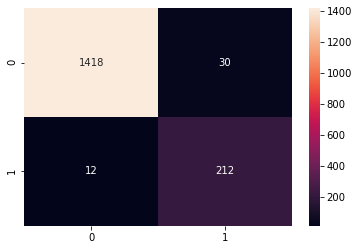

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
X = bigram_wrds
Y = df['label']
x_l, x_test, y_l, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.7)
clf.fit(x_l, y_l)
pred = clf.predict(x_test)
acc = accuracy_score(y_test, pred, normalize = True) * float(100)  
print("计数法测试集准确率:", acc)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = 'd')
train_acc = accuracy_score(y_l, clf.predict(x_l), normalize = True) * float(100)
print("计数法训练集准确率:", train_acc)
print(classification_report(y_test, pred))

TF-IDF法测试集准确率: 96.35167464114832
TF-IDF法训练集准确率: 98.17948717948718
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1448
           1       1.00      0.73      0.84       224

    accuracy                           0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672



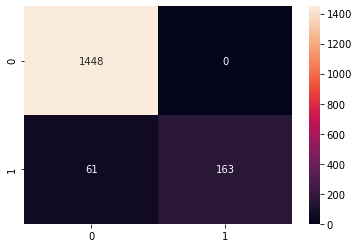

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
X = tfidf_wrds
Y = df['label']
x_l, x_test, y_l, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.7)
clf.fit(x_l, y_l)
pred = clf.predict(x_test)
acc = accuracy_score(y_test, pred, normalize = True) * float(100)  
print("TF-IDF法测试集准确率:", acc)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = 'd')
train_acc = accuracy_score(y_l, clf.predict(x_l), normalize = True) * float(100)
print("TF-IDF法训练集准确率:", train_acc)
print(classification_report(y_test, pred))